## Final Project Submission

Please fill out:
* Student name: Paul Raymond
* Student pace: Full time
* Scheduled project review date/time: 
* Instructor name: Brandon Lewis
* Blog post URL:

My primary focus for my Module 3 Project will be executing various classification methods on a set of data. Additionally, I will integrate Time Series and NLP analysis into the worklfow.

I've chosen a dataset provided by The New York Times that includes data on articles and comments written during Jan-April 2017 and Jan-April 2018.

What I plan to measure is whether features - numerical, categorical, text - can be used to accurately predict which comments are selected by NYTimes editors.

__Import initial libraries and packages__

In [3]:
#import standard libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

In [4]:
#move to appropriate sections#
import statsmodels.api as sm
#
import warnings
warnings.filterwarnings('ignore')
#
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
#
import itertools
#
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
#
from scipy.spatial.distance import euclidean as euc
#
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# import pydotplus

___Exploratory Data Analysis___

__Import files and compile the rows__

_Create loop to load each file in the Articles folder_

In [5]:
#import glob for file upload
import glob

In [6]:
path = '/Users/paulraymond/Downloads/nyt-comments/Articles'
all_files = glob.glob(path + "/*")

files = []

for filename in all_files:
    df = pd.read_csv(filename, index_col = None, header=0)
    files.append(df)
    
articles = pd.concat(files, axis=0, ignore_index=True)
articles.head()

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58927e0495d0e0392607e1b3,1129,By KEN BELSON,article,N.F.L. vs. Politics Has Been Battle All Season...,"['Football', 'Super Bowl', 'National Football ...",1,Sports,12,2017-02-02 00:26:16,Pro Football,Despite the national tumult over immigration s...,The New York Times,News,https://www.nytimes.com/2017/02/01/sports/supe...
1,NaN,5893033d95d0e0392607e2d6,3082,By UNKNOWN,article,Voice. Vice. Veracity.,"['Television', 'Home Box Office', 'Girls (TV P...",1,Arts&Leisure,1,2017-02-02 10:00:24,Television,Our critics look at the impact of the HBO show...,The New York Times,News,https://www.nytimes.com/2017/02/02/arts/televi...
2,NaN,5893039595d0e0392607e2da,693,By MANOHLA DARGIS,article,A Stand-Up’s Downward Slide,"['Movies', 'The Comedian (Movie)', 'De Niro, R...",1,Weekend,5,2017-02-02 10:01:53,Unknown,Joined by a cast that includes Edie Falco and ...,The New York Times,Review,https://www.nytimes.com/2017/02/02/movies/the-...
3,NaN,5893109995d0e0392607e2ef,1049,By ALEXANDRA S. LEVINE,article,New York Today: A Groundhog Has Her Day,"['New York City', 'Groundhogs']",1,Metro,0,2017-02-02 10:57:25,Unknown,Thursday: A meet-and-greet with Staten Island ...,The New York Times,briefing,https://www.nytimes.com/2017/02/02/nyregion/ne...
4,NaN,5893114495d0e0392607e2f1,1283,By BONNIE TSUI,article,A Swimmer’s Communion With the Ocean,"['Travel and Vacations', 'Swimming', 'Oceans a...",1,Travel,4,2017-02-02 11:00:03,Unknown,"“We swam in that heaving body of aquamarine, a...",The New York Times,News,https://www.nytimes.com/2017/02/02/travel/hawa...


In [7]:
# view the columns and row info
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8339 entries, 0 to 8338
Data columns (total 16 columns):
abstract            134 non-null object
articleID           8339 non-null object
articleWordCount    8339 non-null int64
byline              8339 non-null object
documentType        8339 non-null object
headline            8339 non-null object
keywords            8339 non-null object
multimedia          8339 non-null int64
newDesk             8339 non-null object
printPage           8339 non-null int64
pubDate             8339 non-null object
sectionName         8339 non-null object
snippet             8339 non-null object
source              8339 non-null object
typeOfMaterial      8339 non-null object
webURL              8339 non-null object
dtypes: int64(3), object(13)
memory usage: 1.0+ MB


Will need to convert pubDate to a date type

In [8]:
# View info on numerical columns
articles.describe()

,articleWordCount,multimedia,printPage
count,8339.000000,8339.000000,8339.000000
mean,1109.057321,27.795899,6.738938
std,831.475454,32.052564,10.145362
min,11.000000,0.000000,0.000000
25%,731.500000,1.000000,0.000000
50%,1008.000000,3.000000,1.000000
75%,1322.500000,68.000000,11.000000
max,16336.000000,68.000000,198.000000


In [9]:
# what is article breakdown by type of material?
material_articles = articles.groupby('typeOfMaterial')['articleID'].count().sort_values(ascending=False)
# material_articles

In [10]:
#what is article breakdown by category?
category_articles = articles.groupby('newDesk')['articleID'].count().sort_values(ascending=False)
# category_articles

Which article was 11 words?

In [11]:
shortest_article = articles.loc[articles['articleWordCount'] == 11]
# shortest_article

16K+ words?

In [12]:
longest_article = articles.loc[articles['articleWordCount'] == 16336]
# longest_article

_Group data by various categories_ 

In [13]:
total_words_author = articles.groupby('byline')['articleWordCount'].sum().sort_values(ascending=False)
total_words_author.head()

byline
By THE EDITORIAL BOARD     170169
By DEB AMLEN               136485
By THE LEARNING NETWORK     94823
By ALEXANDRA S. LEVINE      85997
By PAUL KRUGMAN             79564
Name: articleWordCount, dtype: int64

In [14]:
total_articles_author = articles.groupby('byline')['byline'].count().sort_values(ascending=False)
total_articles_author.head()

byline
By DEB AMLEN                  233
By THE EDITORIAL BOARD        224
By CAROLINE CROSSON GILPIN    159
By NATALIE PROULX             111
By PAUL KRUGMAN               103
Name: byline, dtype: int64

__Check for normality and multicolinearity__

_Complete exploratory analysis on the Articles data_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112ddab70>,
      dtype=object)

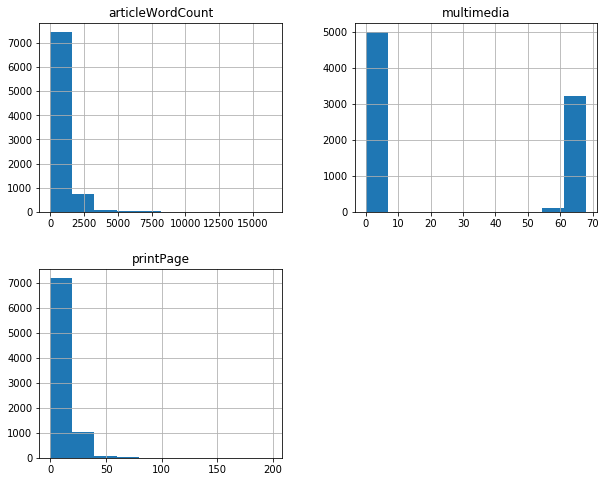

In [15]:
articles.hist(figsize=(10,8))

In [16]:
# normalize data
articles_scale = pd.DataFrame()
articles_scale['articleWordCount'] = (articles['articleWordCount'] - articles['articleWordCount'].min())/(articles['articleWordCount'].max()-articles['articleWordCount'].min())
articles_scale['multimedia'] = (articles['multimedia'] - articles['multimedia'].min()) / (articles['multimedia'].max()- articles['multimedia'].min())
articles_scale['printPage'] = (articles['printPage']- articles['printPage'].min()) / (articles['printPage'].max()- articles['printPage'].min())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11305c4a8>,
      dtype=object)

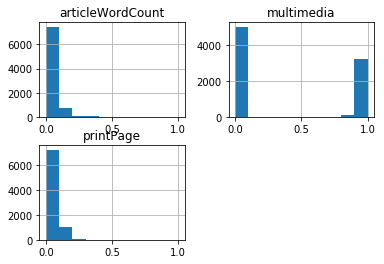

In [17]:
articles_scale.hist()

In [18]:
articles_scale.describe()

,articleWordCount,multimedia,printPage
count,8339.000000,8339.000000,8339.000000
mean,0.067262,0.408763,0.034035
std,0.050933,0.471361,0.051239
min,0.000000,0.000000,0.000000
25%,0.044135,0.014706,0.000000
50%,0.061072,0.044118,0.005051
75%,0.080337,1.000000,0.055556
max,1.000000,1.000000,1.000000


In [19]:
#drop rows with word count of zero?
np.sum(articles_scale['multimedia']== 0.0)

307

In [20]:
# articles_scale['articleWordCount']

In [21]:
articles_scale = articles_scale[articles_scale['articleWordCount'] != 0.0]
# articles_scale_new.describe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c19e4db00>,
      dtype=object)

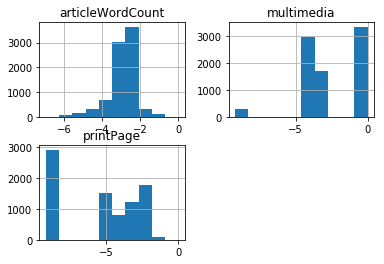

In [22]:
# complete log transformation
articles_scale_log = pd.DataFrame()
articles_scale_log['articleWordCount'] = np.log(articles_scale['articleWordCount']+.0001)
articles_scale_log['multimedia'] = np.log(articles_scale['multimedia']+.0001)
articles_scale_log['printPage'] = np.log(articles_scale['printPage']+.0001)
articles_scale_log.hist()

The log transformation made the 'articleWordCount' column more normally distributed. 

I'll now perform one-hot encoding on the 'newDesk' category alone; other categories not much valuable given the added dimensionality.

In [23]:
#create df for category data
articles_cat = articles['newDesk']

In [24]:
#perform one-hot encoding
articles_scale_one_hot = pd.get_dummies(articles_cat)
articles_scale_one_hot.head()

,Arts&Leisure,BookReview,Business,Climate,Culture,Dining,EdLife,Editorial,Express,Foreign,...,Summary,SundayBusiness,TStyle,Travel,Unknown,Upshot,Video,Washington,Weekend,Well
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [25]:
#concat the numerical and categorical dataframes
df_articles = pd.concat([articles_scale_log, articles_scale_one_hot], axis=1)
df_articles.shape

(8339, 46)

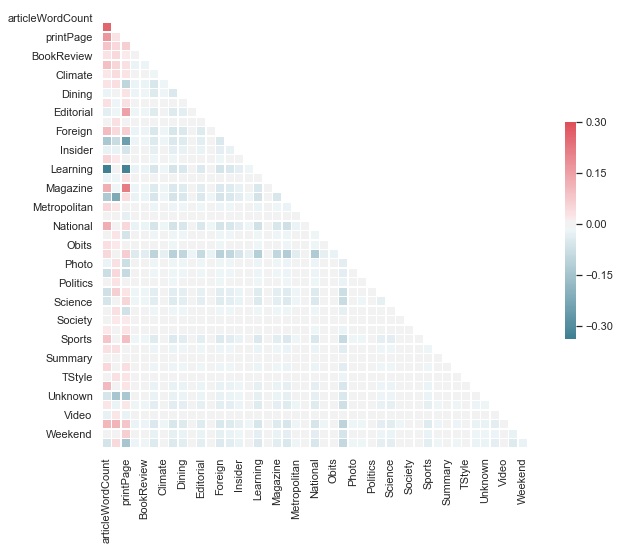

In [26]:
#plot covariance matrix
sns.set(style='white')
corr = df_articles.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10,8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

Not much correlation among the categories in the article dataset.

I'll do the same exploratory analysis process for comments.

_Create loop to import comment files_

In [27]:
path2 = '/Users/paulraymond/Downloads/nyt-comments/Comments'
all_files2 = glob.glob(path2 + "/*")

files2 = []

for filename in all_files2:
    df = pd.read_csv(filename, index_col = None, header=0)
    files2.append(df)
    
comments = pd.concat(files2, axis=0, ignore_index=True)

In [28]:
comments.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,...,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1517529462,5a7258e410f40f00018bed7d,835.0,The snake-filled heads comment made me think o...,25791250.0,25791250.0,<br/>,comment,1.517508e+09,1.0,...,approved,1.0,0.0,Op-Ed,1517529462,Jennie,79172841.0,WA,NaN,NaN
1,1517529428,5a7258e410f40f00018bed7d,835.0,She-devil reporting for duty!,25795675.0,25795675.0,<br/>,comment,1.517527e+09,1.0,...,approved,1.0,0.0,Op-Ed,1517529428,Nice White Lady,66376882.0,Seattle,NaN,NaN
2,1517529427,5a7258e410f40f00018bed7d,835.0,XX is the new mark of the devil.,25792078.0,25792078.0,<br/>,comment,1.517511e+09,1.0,...,approved,1.0,0.0,Op-Ed,1517529427,Stan Sutton,27924638.0,"Westchester County, NY",NaN,NaN
3,1517529425,5a7258e410f40f00018bed7d,835.0,"""Courtland Sykes"" should be writing for The On...",25791604.0,25791604.0,<br/>,comment,1.517510e+09,1.0,...,approved,1.0,0.0,Op-Ed,1517529425,Phil Carson,31909107.0,Denver,NaN,NaN
4,1517529418,5a7258e410f40f00018bed7d,835.0,"I happen to descend for a few of them, because...",25795241.0,25795241.0,<br/>,comment,1.517525e+09,1.0,...,approved,1.0,0.0,Op-Ed,1517529418,Abby,55271958.0,Tucson,NaN,NaN


In [29]:
#view type of materials
comments.typeOfMaterial.unique()

array(['Op-Ed', 'News', 'Editorial', 'News Analysis', 'Review',
       'briefing', 'Biography', 'An Appraisal', 'Brief',
       'Obituary (Obit)', 'Question', 'Blog', 'Letter', 'Interview'],
      dtype=object)

In [30]:
material_comments = comments.groupby('typeOfMaterial')['commentID'].count().sort_values(ascending=False)
material_comments

typeOfMaterial
News               1050659
Op-Ed               666450
Editorial           127167
News Analysis        20562
Review               13783
Blog                  9374
briefing              4969
Obituary (Obit)       4361
Letter                1339
Question               647
Brief                  380
Interview              217
Biography               58
An Appraisal             9
Name: commentID, dtype: int64

Before moving forward with feature scaling, I'll choose a random sample of 30K rows of comments to make subsequent preprocessing and modeling quicker.

In [31]:
comments = comments.sample(30000)

__comment text__ (of course!), __createDate, inReplyTo, recommendations, recommendedFlag, replyCount, reportAbuseFlag, sharing, timespeople, userID, parentID, editorsSelection, commentSequence__, and __commentID__ should be insightful comments.

In [ ]:
#check for null values
# comments.isna().sum()

I'll drop the following columns with substantial null values: __parentUserDisplayName, userTitle, userURL__ as well as columns with malformated data.

In [33]:
#drop columns
comments.drop(['reportAbuseFlag','parentUserDisplayName', 'userTitle', 'userURL', 'approveDate', 'updateDate', 'commentTitle'], axis=1, inplace=True)

In [34]:
comments.drop('recommendedFlag', axis=1, inplace=True)

In [35]:
#convert columns to string format
comments['commentID'] = comments['commentID'].astype(str)
comments['createDate'] = comments['createDate'].astype(str) #convert to datetime later
comments['parentID'] = comments['parentID'].astype(str)
comments['printPage'] = comments['printPage'].astype(str)
comments['userID'] = comments['userID'].astype(str)
comments['inReplyTo'] = comments['inReplyTo'].astype(str)
comments['commentSequence'] = comments['commentSequence'].astype(str)

In [36]:
comments.describe()

,articleWordCount,depth,editorsSelection,recommendations,replyCount,sharing,timespeople,trusted
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,1264.053367,1.269367,0.018000,20.353533,0.433100,0.086433,0.959867,0.034533
std,824.752160,0.454476,0.132953,119.234250,1.760803,0.281008,0.196275,0.182598
min,33.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,836.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,1125.000000,1.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000
75%,1442.000000,2.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000
max,11278.000000,4.000000,1.000000,6295.000000,101.000000,1.000000,1.000000,1.000000


In [37]:
# normalize data
## complete scaling for comments dataset
comments_scale = pd.DataFrame()
comments_scale['articleWordCount'] = (comments['articleWordCount'] - comments['articleWordCount'].min())/(comments['articleWordCount'].max()-comments['articleWordCount'].min())
comments_scale['depth'] = (comments['depth'] - comments['depth'].min()) / (comments['depth'].max()- comments['depth'].min())
comments_scale['editorsSelection'] = (comments['editorsSelection']- comments['editorsSelection'].min()) / (comments['editorsSelection'].max()- comments['editorsSelection'].min())
comments_scale['recommendations'] = (comments['recommendations'] - comments['recommendations'].min()) / (comments['recommendations'].max()- comments['recommendations'].min())
comments_scale['replyCount'] = (comments['replyCount']- comments['replyCount'].min()) / (comments['replyCount'].max()- comments['replyCount'].min())
comments_scale['sharing'] = (comments['sharing']- comments['sharing'].min()) / (comments['sharing'].max()- comments['sharing'].min())
comments_scale['timespeople'] = (comments['timespeople'] - comments['timespeople'].min()) / (comments['timespeople'].max()- comments['timespeople'].min())
comments_scale['trusted'] = (comments['trusted']- comments['trusted'].min()) / (comments['trusted'].max()- comments['trusted'].min())

In [38]:
# comments_scale.hist()

In [39]:
# complete log transform
comments_scale_log = pd.DataFrame()
comments_scale_log['articleWordCount'] = np.log(comments_scale['articleWordCount']+.00001)
comments_scale_log['depth'] = np.log(comments_scale['depth']+.00001)
comments_scale_log['editorsSelection'] = np.log(comments_scale['editorsSelection']+.00001)
comments_scale_log['recommendations'] = np.log(comments_scale['recommendations']+.00001)
comments_scale_log['replyCount'] = np.log(comments_scale['replyCount']+.00001)
comments_scale_log['timespeople'] = np.log(comments_scale['timespeople']+.00001)
comments_scale_log['trusted'] = np.log(comments_scale['trusted']+.00001)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4b2b5e80>,
      dtype=object)

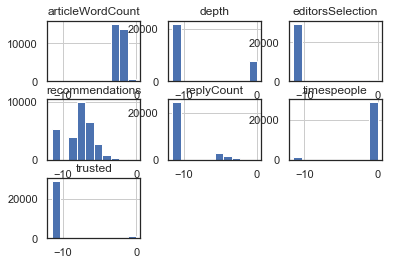

In [40]:
comments_scale_log.hist()

In [41]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1227172 to 82172
Data columns (total 26 columns):
articleID           30000 non-null object
articleWordCount    30000 non-null float64
commentBody         30000 non-null object
commentID           30000 non-null object
commentSequence     30000 non-null object
commentType         30000 non-null object
createDate          30000 non-null object
depth               30000 non-null float64
editorsSelection    30000 non-null int64
inReplyTo           30000 non-null object
newDesk             30000 non-null object
parentID            30000 non-null object
permID              30000 non-null object
picURL              30000 non-null object
printPage           30000 non-null object
recommendations     30000 non-null float64
replyCount          30000 non-null float64
sectionName         27640 non-null object
sharing             30000 non-null int64
status              30000 non-null object
timespeople         30000 non-null float64


I'll create a categorical dataframe and perform one-hot encoding.

In [42]:
comments_cat = comments[['commentType','newDesk','sectionName','status','typeOfMaterial']]
#removed userLocation for now; too many columns after one-hot encoding

In [43]:
comments_cat_one_hot = pd.get_dummies(comments_cat)
comments_cat_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1227172 to 82172
Columns: 110 entries, commentType_comment to typeOfMaterial_briefing
dtypes: uint8(110)
memory usage: 3.4 MB


Merge the numerical and categorical dataframes.

In [44]:
df_comments = pd.concat([comments_scale_log, comments_cat_one_hot], axis=1)

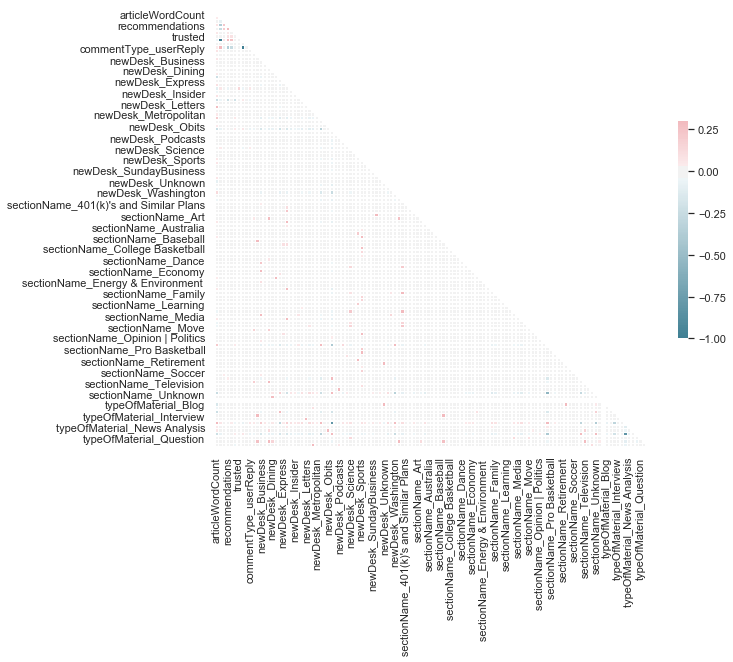

In [45]:
#plot covariance matrix
sns.set(style='white')
corr = df_comments.corr() #update with normalized dataset
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10,8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

Also low correlation among many features for comments dataset although some pairs high large negative correlation.

I'll use the preprocessed datasets moving forward.

In [52]:
#select columns from each dataset
articles_time = df_articles

In [53]:
#select columns from each dataset
comments_time = df_comments

In [ ]:
comments_time.info()

In [56]:
#change column to datetime format
articles_time['date'] = pd.to_datetime(articles_time['pubDate'])

KeyError: 'pubDate'

In [58]:
# comments_time['date'] = pd.to_datetime(comments_time['createDate'])

In [59]:
# comments_time.head()

In [61]:
#set index
articles_time.set_index('date', inplace=True)

In [60]:
# comments_time.set_index('date', inplace=True)

In [63]:
#change pubdate format
# articles_time['pubDate'] = pd.to_datetime(articles_time['pubDate'], format='%Y/%m/%d')
# articles_time['pubDate'] = articles_time['pubDate'].dt.date
# articles_time.pubDate = pd.to_datetime(articles_time.pubDate)

In [ ]:
# comments_time['date_update'] = pd.to_datetime(comments_time['date_update'], format='%Y/%m/%d')
# comments_time['date_update'] = comments_time['date_update'].dt.date
# comments_time.date_update = pd.to_datetime(comments_time.date_update)

In [64]:
articles_time.head()
# comments_time.tail()

,articleWordCount,multimedia,printPage,Arts&Leisure,BookReview,Business,Climate,Culture,Dining,EdLife,...,Summary,SundayBusiness,TStyle,Travel,Unknown,Upshot,Video,Washington,Weekend,Well
date,,,,,,,,,,,,,,,,,,,,,
2017-02-02 00:26:16,-2.679697,-4.212731,-2.801712,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-02 10:00:24,-1.670163,-4.212731,-5.268661,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-02 10:01:53,-3.173032,-4.212731,-3.674877,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2017-02-02 10:57:25,-2.753830,-4.212731,-9.210340,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-02 11:00:03,-2.550825,-4.212731,-3.897035,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [68]:
df = articles_time.groupby('pubDate')['articleID', 'pubDate'].count()

KeyError: 'pubDate'

In [ ]:
df.plot()

In [ ]:
#Group data
df_year = df.groupby(pd.Grouper(freq='A'))
df_year.head()

In [ ]:
#plot
df_year.plot(style='.b')

In [ ]:
df_week = df.groupby(pd.Grouper(freq='W'))
week_mean = df_week.mean()

In [ ]:
week_mean.plot(figsize=(10, 8))

In [ ]:
#view trends and seasonality

In [ ]:
rolmean = df_year.articleID.rolling(window=4, center= False).mean()
rolstd = df_year.articleID.rolling(window=12, center=False).std()

In [ ]:
df_year.plot()

In [ ]:
rolmean.plot()

In [ ]:
rolstd.plot()

In [ ]:
fig = plt.figure(figsize=(12, 6))
# orig = plt.plot(df_year.articleID, color='blue', label='Original')
# mean = plt.plot(rolmean, color='red', label='Rolling Mean')
# std = plt.plot(rolstd, color='black', label='Rolling Std')
# plt.legend(loc='best')
# plt.title('Rolling Mean & Standard Deviation')
# plt.show()
## error due to shape mismatch. need to debug

In [ ]:
#Dickey-Fuller test to verify stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
df_year.head()

In [ ]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_year['articleID'])

In [ ]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

In [ ]:
#do same for comments

In [ ]:
# df_comments = comments_time.groupby('date')['commentID','createDate'].count()

In [ ]:
# df_comments['createDate'] = pd.to_datetime(df_comments['createDate'])

In [ ]:
# df_comments.head()

In [ ]:
# df_comments.info()

In [ ]:
# df2_year = df_comments.groupby(pd.Grouper(freq='A'))

In [ ]:
# df2_year.plot(figsize=(10,8))

__NLP Analysis__

In [69]:
path2 = '/Users/paulraymond/Downloads/nyt-comments/Comments'
all_files2 = glob.glob(path2 + "/*")

files2 = []

for filename in all_files2:
    df = pd.read_csv(filename, index_col = None, header=0)
    files2.append(df)
    
comments = pd.concat(files2, axis=0, ignore_index=True)

In [70]:
#create train and test sets
train = comments[:499999]
test = comments[500000:599999]

In [71]:
#organize by flagged comments and unflagged comments, and view first rows
comments_train = train['commentBody']
target_train = train['editorsSelection']
comments_test = test['commentBody']
target_test = test['editorsSelection']
print(comments_train.head(1))
print(target_train.head(1))
print(comments_test.head(1))
print(target_test.head(1))
target_train.unique()

0    The snake-filled heads comment made me think o...
Name: commentBody, dtype: object
0    0
Name: editorsSelection, dtype: int64
500000      Before I read this article I had never thoug...
Name: commentBody, dtype: object
500000    0
Name: editorsSelection, dtype: int64


array([0, 1])

In [72]:
#import libraries used in lab
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
# from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np

In [73]:
print(comments_train.shape)
print(target_train.shape)
print(comments_test.shape)
print(target_test.shape)

(499999,)
(499999,)
(99999,)
(99999,)


In [74]:
#create list of stop words
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', 'br/',"'"]

In [75]:
#test the nltk method
def process_comments(comment):
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token not in stopwords_list]
    return stopwords_removed

In [76]:
processed_data = list(map(process_comments, comments_train))

In [77]:
processed_data[0]

['the',
 'snake-filled',
 'heads',
 'comment',
 'made',
 'think',
 'medusa',
 'i',
 'hope',
 'loses',
 'retrograde']

In [78]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

275082

In [79]:
comments_concat = []
for comment in processed_data:
    comments_concat += comment

In [80]:
comments_freqdist = FreqDist(comments_concat)
comments_freqdist.most_common(20)

[('i', 396086),
 ("'s", 249705),
 ('trump', 182428),
 ('the', 177937),
 ("n't", 161772),
 ('people', 118393),
 ('would', 114759),
 ('’', 104447),
 ('it', 98198),
 ('one', 97339),
 ('like', 87709),
 ('us', 76157),
 ('get', 59842),
 ('many', 58948),
 ('and', 58582),
 ('time', 55970),
 ('this', 55481),
 ('we', 54666),
 ('even', 53858),
 ('think', 51769)]

In [81]:
#would like to remove additional prepositions and stop words and consider bigrams

In [82]:
#add bigrams and threshold

In [83]:
# Vectorizing with TF-IDF

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
vectorizer = TfidfVectorizer()

In [86]:
tf_idf_data_train = vectorizer.fit_transform(comments_train)

In [87]:
tf_idf_data_test = vectorizer.transform(comments_test)

In [88]:
#modeling the data

In [89]:
tf_idf_data_train.shape

(499999, 149134)

In [90]:
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 50.2237684475369
Percentage of columns containing 0: 0.9996632305949849


In [91]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=10)
#should this be 100?

In [92]:
nb_classifier.fit(tf_idf_data_train, target_train)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [93]:
rf_classifier.fit(tf_idf_data_train, target_train)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [94]:
print(target_train.shape)
print(nb_train_preds.shape)

(499999,)
(499999,)


In [95]:
nb_train_score = accuracy_score(target_train, nb_train_preds)
nb_test_score = accuracy_score(target_test, nb_test_preds)
rf_train_score = accuracy_score(target_train, rf_train_preds)
rf_test_score = accuracy_score(target_test, rf_test_preds)

In [96]:
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.9842 		 Testing Accuracy: 0.9791

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9957 		 Testing Accuracy: 0.9791


In [97]:
#import classification report library
from sklearn.metrics import classification_report

In [98]:
print('NB Classification report:')
print(classification_report(target_test, nb_test_preds))
print("-----------------------------------------------------")
print('RF Classification report:')
print(classification_report(target_test, rf_test_preds))

NB Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     97910
           1       0.00      0.00      0.00      2089

   micro avg       0.98      0.98      0.98     99999
   macro avg       0.49      0.50      0.49     99999
weighted avg       0.96      0.98      0.97     99999

-----------------------------------------------------
RF Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     97910
           1       0.00      0.00      0.00      2089

   micro avg       0.98      0.98      0.98     99999
   macro avg       0.49      0.50      0.49     99999
weighted avg       0.96      0.98      0.97     99999



In [99]:
#both models did a poor job predicting selected comments

In [100]:
#plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
#import confusion matrix library
from sklearn.metrics import confusion_matrix
import itertools

Confusion matrix, without normalization
[[97910  2089]
 [    0     0]]


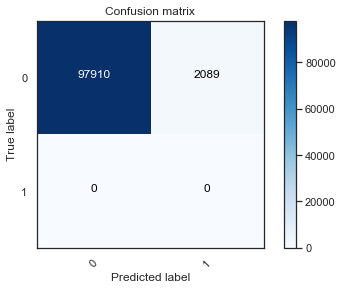

In [102]:
cnf_matrix = confusion_matrix(nb_test_preds, target_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [103]:
#import ROC and AUC libraries
from sklearn.metrics import roc_curve, auc

AUC: 0.5


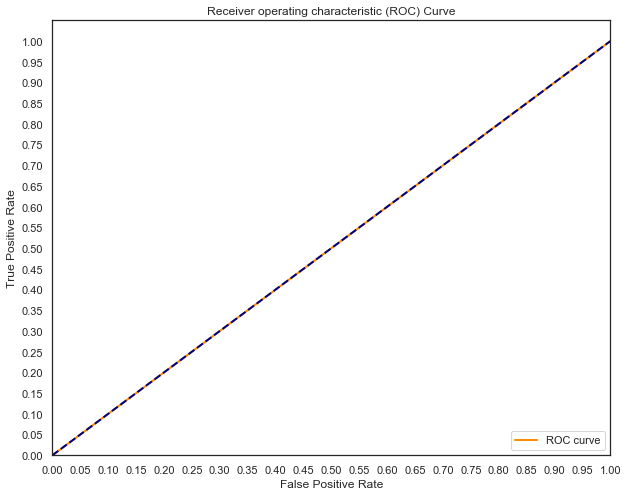

In [104]:
#false and true positive rate
fpr, tpr, thresholds = roc_curve(target_test, nb_test_preds)
#seaborn styling
# sns.set_style('whitegrid')
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw=2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [105]:
# the curve shows that the model is no better than random guessing!

In [106]:
#address class imbalance

In [107]:
#import class imbalance libraries
from imblearn.over_sampling import SMOTE, ADASYN

In [108]:
#use SMOTE to imporve the model's performance on the minority class

In [109]:
print(target_train.value_counts())

0    492130
1      7869
Name: editorsSelection, dtype: int64


In [110]:
#less than 2% of target values are selected ("1")

In [111]:
#import train test split library
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [112]:
# X_train_resampled, y_train_resampled = SMOTE().fit_sample(comments_train, target_train)
# print(pd.Series(y_train_resampled).value_counts())

In [113]:
#try over sampling
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# >>> smote_nc = SMOTENC(categorical_features=[0, 2], random_state=0)

In [114]:
# X, y = make_classification(n_samples=500000, n_features=10, n_informative=2,
#                             n_redundant=0, n_repeated=0, n_classes=3,
#                             n_clusters_per_class=1,
#                             weights=[0.01, 0.05, 0.94],
#                             class_sep=0.8, random_state=0)

In [115]:
# ros = RandomOverSampler(random_state=0)

In [116]:
# X_resampled, y_resampled = ros.fit_resample(comments_list, target_train)

The SMOTE method is an issue with text. Will first try balancing samples in brute force approach.

In [117]:
target_train.get_values().sum()

7869

7869 comments in the train data were selected by editors. I'll concat two new dataframes of this length for balanced sample.

In [118]:
selected = train[train['editorsSelection']==1]
non_selected = train[train['editorsSelection']==0]

In [119]:
selected.shape

(7869, 34)

In [120]:
non_selected_sample = non_selected.sample(7869)
non_selected_sample.shape

(7869, 34)

In [121]:
# concat the dataframes
df_nlp = pd.concat([selected, non_selected_sample], axis=0)
# df_nlp.info()

In [135]:
df_comments_train = df_nlp['commentBody'] 
df_comments_train.shape

(15738,)

In [123]:
df_target_train = df_nlp['editorsSelection']

In [124]:
#perform classification 

In [125]:
vectorizer = TfidfVectorizer()

In [136]:
tf_idf_data_train = vectorizer.fit_transform(df_comments_train)

In [137]:
tf_idf_data_test = vectorizer.transform(comments_test)
#using only subset to make train ~25%

In [138]:
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))
##double check the equation

Average Number of Non-Zero Elements in Vectorized Articles: 63.69614944719787
Percentage of columns containing 0: 0.99827531275189


In [139]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=10)
#should this be 100?

In [140]:
nb_classifier.fit(tf_idf_data_train, df_target_train)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [141]:
rf_classifier.fit(tf_idf_data_train, df_target_train)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [142]:
nb_train_score = accuracy_score(df_target_train, nb_train_preds)
nb_test_score = accuracy_score(target_test, nb_test_preds)
rf_train_score = accuracy_score(df_target_train, rf_train_preds)
rf_test_score = accuracy_score(target_test, rf_test_preds)

In [144]:
print('NB Classification report:')
print(classification_report(target_test, nb_test_preds))
print("-----------------------------------------------------")
print('RF Classification report:')
print(classification_report(target_test, rf_test_preds))

NB Classification report:
              precision    recall  f1-score   support

           0       0.99      0.20      0.33     97910
           1       0.02      0.93      0.05      2089

   micro avg       0.21      0.21      0.21     99999
   macro avg       0.51      0.56      0.19     99999
weighted avg       0.97      0.21      0.33     99999

-----------------------------------------------------
RF Classification report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     97910
           1       0.04      0.57      0.07      2089

   micro avg       0.69      0.69      0.69     99999
   macro avg       0.51      0.63      0.44     99999
weighted avg       0.97      0.69      0.79     99999



In [134]:
#very slight improvement

In [ ]:
#recall is high because

In [ ]:
#issues are: 1. brute force oversampling 2. the test set is significantly greater than train set